Here is the data analysis on the alternative streets other than King street travel time after the King street pilot project began. Only certain vehicle including street cars are allowed to drive on King Street during the pilot project.
All other vehicle need to take alternative routes. Despite street car will flow smoother for transit riders, drivers will take longer to drive in downtown. Here is the Data shows different streets travel time (tt) from Nov. 2017 to Oct. 2018.
The goal is to comparing the pilot tt with the baseline tt of all other east to west streets and understand how the pilot project affects tt on other streets.

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv('monthly_aggregate_travel_time.csv') #travel time is in minutes
df.head()
df.tail()

,month,street,direction,from_intersection,to_intersection,day_type,time_period,baseline_tt_minutes,pilot_tt_minutes
1551,Oct '18,Yonge,Northbound,Front,Dundas,Weekday,Midday (10:00-16:00),8.3,8.8
1552,Oct '18,Yonge,Northbound,Front,Dundas,Weekday,PM Peak (16:00-19:00),8.1,9.8
1553,Oct '18,Yonge,Northbound,Front,Dundas,Weekend,Afternoon (12:00-17:00),8.1,9.7
1554,Oct '18,Yonge,Northbound,Front,Dundas,Weekend,Evening (17:00-23:00),7.6,7.5
1555,Oct '18,Yonge,Northbound,Front,Dundas,Weekend,Morning (08:00-12:00),5.3,5.8


In [3]:
#Check features types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 9 columns):
month                  1556 non-null object
street                 1556 non-null object
direction              1556 non-null object
from_intersection      1556 non-null object
to_intersection        1556 non-null object
day_type               1556 non-null object
time_period            1556 non-null object
baseline_tt_minutes    1556 non-null float64
pilot_tt_minutes       1556 non-null float64
dtypes: float64(2), object(7)
memory usage: 109.5+ KB


In [4]:
#non-null object means there is no null values. We can verify this by checking Nans 
df.isna().sum()
#No null value exist

month                  0
street                 0
direction              0
from_intersection      0
to_intersection        0
day_type               0
time_period            0
baseline_tt_minutes    0
pilot_tt_minutes       0
dtype: int64

In [5]:
#Let's compare the baseline and pilot travel time(tt) data in general
df[['baseline_tt_minutes', 'pilot_tt_minutes']].describe()

,baseline_tt_minutes,pilot_tt_minutes
count,1556.000000,1556.000000
mean,8.262725,8.601542
std,3.484510,3.619330
min,2.800000,3.000000
25%,5.300000,5.500000
50%,7.800000,8.100000
75%,10.900000,11.300000
max,17.500000,21.700000


Overall, the pilot travel time is slightly higher than the baseline travel time (which is not a surprise). Lets plot a empirical cumulative distribution function (ECDF) of the pilot and baseline data.

In [6]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

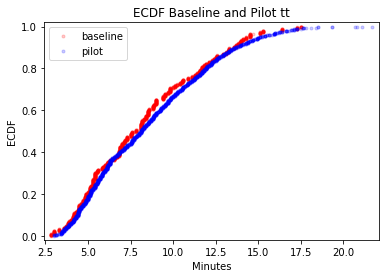

In [7]:
x1, y1 = ecdf(df['baseline_tt_minutes'])
x2, y2 = ecdf(df['pilot_tt_minutes'])
_ = plt.plot(x1, y1, marker = '.', linestyle = 'none', color = 'red', label = 'baseline', alpha = 0.2)
_ = plt.plot(x2, y2, marker='.', linestyle='none', color='blue', label = 'pilot', alpha=0.2)
_ = plt.xlabel('Minutes')
_ = plt.ylabel('ECDF')
_ = plt.title('ECDF Baseline and Pilot tt')
_ = plt.legend()
_ = plt.margins(0.02)

Both are very similar but the pilot data contain higher travel time values than the baseline data. 

In [8]:
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1) - np.mean(data_2)

    return diff

diff_of_mean = diff_of_means(df.pilot_tt_minutes, df.baseline_tt_minutes)
diff_of_mean

0.33881748071981654

The mean difference is only 0.3388 minutes between these two data. To investigate further, first need to find out if the pilot data is actually higher than baseline data by chance. The procedure is applying bootstrap method to generate 10000 samples of data and see if it has larger mean difference than the original samples.  One method is to generate a permutation replicate samples by combining these two data sets. 


In [9]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

In [10]:
def draw_perm_reps(data_1, data_2, func, size = 1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

perm_replicates = draw_perm_reps(df.pilot_tt_minutes, df.baseline_tt_minutes, diff_of_means, size=10000)
p = np.sum(perm_replicates >= diff_of_mean) / len(perm_replicates)
p

0.0038

In [11]:
conf_int = np.percentile(perm_replicates, [2.5, 97.5])
conf_int

array([-0.2447365 ,  0.24525064])

The p value is 0.0038 which means only 0.38% chance that the theoretical mean difference is larger than the actual mean difference. This shows the probability is greater for the pilot tt mean value to be larger than the baseline tt mean value. The mean difference is 0.33881748071981654 which is above the upper limit of the confidence interval between [-0.25334512,  0.25154884].


How is the correlation between the baseline and pilot travel time?

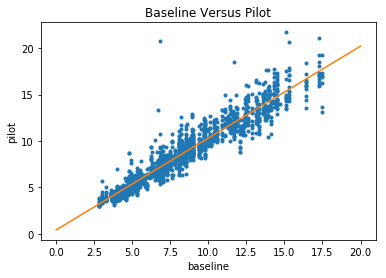

In [12]:
#Make a scatter plot, we can see the baseline and pilot travel time are highly correlated 
_ = plt.plot('baseline_tt_minutes', 'pilot_tt_minutes', data = df, marker = '.', linestyle = 'none')
#Label the axes
_ = plt.xlabel('baseline')
_ = plt.ylabel('pilot')
_ = plt.title('Baseline Versus Pilot')

#Add a regression line
a, b = np.polyfit(df['baseline_tt_minutes'], df['pilot_tt_minutes'], 1)

x = np.array([0, 20])
y = a*x + b
_ = plt.plot(x, y)
_ = plt.xlabel('baseline')
_ = plt.ylabel('pilot')
#Show the result
plt.show()

In [13]:
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix: corr_mat
    corr_mat = np.corrcoef(x, y)

    # Return entry [0,1]
    return corr_mat[0,1]
print(pearson_r(df['pilot_tt_minutes'], df['baseline_tt_minutes']))

0.9517686779479265


The pearson correlation is 0.95, which shows strong correlation between pilot and baseline. Next, let's plot the baseline and pilot travel time on the alternative streets using boxplots.

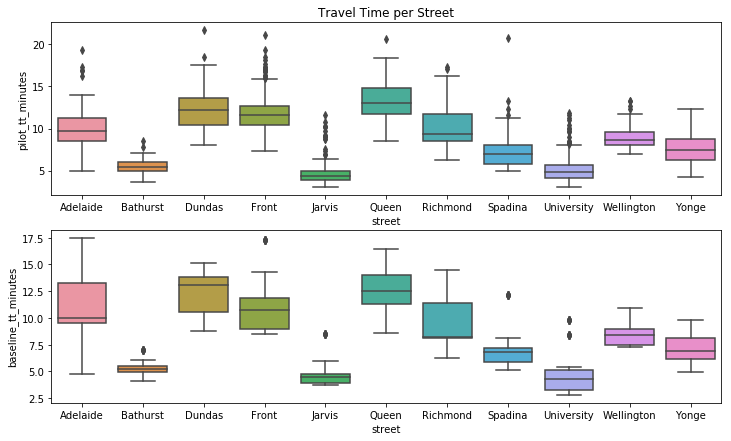

In [14]:
#Create box plots with Seaborn for both baseline and pilot tt data

f, axes = plt.subplots(2, 1, figsize = (12, 7))
sns.boxplot(x = 'street', y = 'pilot_tt_minutes', data = df, orient='v' , ax=axes[0])
sns.boxplot(x = 'street', y = 'baseline_tt_minutes', data = df, orient='v' , ax=axes[1])
axes[0].set_title('Travel Time per Street')


plt.show()

How do we explain the outliers from the pilot tt? let's check out the outliers from the pilot tt data.


The outliers not existing in baseline travel time. What is the reason behind this? Best to obtain data prior to Oct/Nov. 2017 and find out the results.

The streets with many outliers are investigated below. These streets are listed as follows, Adelaide, Dundas, Front, Jarvis, Spadina and University

In [15]:
#Comparing the baseline and pilot stats at each street
#Adelaide
df[df['street'] == 'Adelaide'].describe()

,baseline_tt_minutes,pilot_tt_minutes
count,56.000000,56.000000
mean,10.678571,10.294643
std,3.299130,3.010794
min,4.800000,5.000000
25%,9.500000,8.575000
50%,10.000000,9.700000
75%,13.300000,11.300000
max,17.500000,19.300000


In [16]:
#Dundas
df[df['street'] == 'Dundas'].describe()

,baseline_tt_minutes,pilot_tt_minutes
count,162.000000,162.000000
mean,12.308642,12.134568
std,1.930867,2.336115
min,8.800000,8.000000
25%,10.600000,10.425000
50%,13.050000,12.200000
75%,13.800000,13.600000
max,15.100000,21.700000


In [17]:
df[df['street'] == 'Front'].describe()

,baseline_tt_minutes,pilot_tt_minutes
count,168.000000,168.000000
mean,11.100000,11.823810
std,2.365622,2.505903
min,8.500000,7.300000
25%,9.000000,10.400000
50%,10.750000,11.600000
75%,11.900000,12.625000
max,17.300000,21.100000


In [18]:
df[df['street'] == 'Jarvis'].describe()

,baseline_tt_minutes,pilot_tt_minutes
count,168.0000,168.000000
mean,4.7500,4.839881
std,1.2088,1.559293
min,3.7000,3.100000
25%,3.9000,3.900000
50%,4.5000,4.400000
75%,4.8000,5.000000
max,8.5000,11.600000


In [19]:
df[df['street'] == 'Spadina'].describe()

,baseline_tt_minutes,pilot_tt_minutes
count,162.000000,162.000000
mean,7.037037,7.182716
std,1.651647,1.908646
min,5.100000,4.900000
25%,5.900000,5.800000
50%,6.850000,7.000000
75%,7.200000,8.000000
max,12.100000,20.800000


In [20]:
df[df['street'] == 'University'].describe()

,baseline_tt_minutes,pilot_tt_minutes
count,168.000000,168.000000
mean,4.735714,5.223214
std,1.965672,1.822874
min,2.800000,3.000000
25%,3.300000,4.100000
50%,4.300000,4.800000
75%,5.100000,5.700000
max,9.800000,11.800000


Finding the tt outliers in minutes which is 1.5*(Q3-Q1) + Q3

-Adelaide is 15.3875
-Dundas is 18.3625
-Front is 15.9625
-Jarvis is 6.65 
-Spadina is 11.3
-University is 18.3625

In [21]:
#Adelaide outliers table
df[(df['street'] == 'Adelaide') & (df['pilot_tt_minutes'] > 15.3875)]

,month,street,direction,from_intersection,to_intersection,day_type,time_period,baseline_tt_minutes,pilot_tt_minutes
640,Apr '18,Adelaide,Eastbound,Bathurst,Jarvis,Weekday,PM Peak (16:00-19:00),17.5,16.2
773,May '18,Adelaide,Eastbound,Bathurst,Jarvis,Weekday,PM Peak (16:00-19:00),17.5,17.3
894,Jun '18,Adelaide,Eastbound,Bathurst,Jarvis,Weekday,PM Peak (16:00-19:00),17.5,17.0
1160,Aug '18,Adelaide,Eastbound,Bathurst,Jarvis,Weekday,PM Peak (16:00-19:00),17.5,19.3
1293,Sep '18,Adelaide,Eastbound,Bathurst,Jarvis,Weekday,PM Peak (16:00-19:00),17.5,16.9


On Adelaide, the baseline tt and pilot tt are almost identical, the pilot tt is shorter in April but longer in August of 2018
All happened in the PM Peak.

In [22]:
#Dundas outliers table
df[(df['street'] == 'Dundas') & (df['pilot_tt_minutes'] > 18.3625)]


,month,street,direction,from_intersection,to_intersection,day_type,time_period,baseline_tt_minutes,pilot_tt_minutes
792,May '18,Dundas,Eastbound,Bathurst,Jarvis,Weekday,Evening (19:00-23:00),11.7,18.5
1454,Oct '18,Dundas,Westbound,Jarvis,Bathurst,Weekday,PM Peak (16:00-19:00),15.1,21.7


On Dundas, two outliers exist in May and October 2018. Need to determine the reason for these delays. 
Both are in the afternoon(PM Peak) and evening.

In [23]:
#Front outliers table
df[(df['street'] == 'Front') & (df['pilot_tt_minutes'] >= 15.9625)]

,month,street,direction,from_intersection,to_intersection,day_type,time_period,baseline_tt_minutes,pilot_tt_minutes
38,Nov '17,Front,Eastbound,Bathurst,Jarvis,Weekday,PM Peak (16:00-19:00),17.3,18.5
45,Nov '17,Front,Westbound,Yonge,Bathurst,Weekday,PM Peak (16:00-19:00),14.3,16.9
164,Dec '17,Front,Eastbound,Bathurst,Jarvis,Weekday,PM Peak (16:00-19:00),17.3,17.1
416,Feb '18,Front,Eastbound,Bathurst,Jarvis,Weekday,PM Peak (16:00-19:00),17.3,17.0
423,Feb '18,Front,Westbound,Yonge,Bathurst,Weekday,PM Peak (16:00-19:00),14.3,17.3
542,Mar '18,Front,Eastbound,Bathurst,Jarvis,Weekday,PM Peak (16:00-19:00),17.3,16.0
675,Apr '18,Front,Eastbound,Bathurst,Jarvis,Weekday,PM Peak (16:00-19:00),17.3,17.3
802,May '18,Front,Eastbound,Bathurst,Jarvis,Weekday,PM Peak (16:00-19:00),17.3,16.7
929,Jun '18,Front,Eastbound,Bathurst,Jarvis,Weekday,PM Peak (16:00-19:00),17.3,19.3
936,Jun '18,Front,Westbound,Yonge,Bathurst,Weekday,PM Peak (16:00-19:00),14.3,16.4


On Front, more pilot tt are higher than the baseline. All during the PM Peak.

In [24]:
#Jarvis outlier table
df[(df['street'] == 'Jarvis') & (df['pilot_tt_minutes'] > 6.65)]

,month,street,direction,from_intersection,to_intersection,day_type,time_period,baseline_tt_minutes,pilot_tt_minutes
52,Nov '17,Jarvis,Southbound,Dundas,Front,Weekday,PM Peak (16:00-19:00),8.5,10.2
178,Dec '17,Jarvis,Southbound,Dundas,Front,Weekday,PM Peak (16:00-19:00),8.5,9.7
304,Jan '18,Jarvis,Southbound,Dundas,Front,Weekday,PM Peak (16:00-19:00),8.5,9.0
430,Feb '18,Jarvis,Southbound,Dundas,Front,Weekday,PM Peak (16:00-19:00),8.5,9.1
556,Mar '18,Jarvis,Southbound,Dundas,Front,Weekday,PM Peak (16:00-19:00),8.5,7.6
689,Apr '18,Jarvis,Southbound,Dundas,Front,Weekday,PM Peak (16:00-19:00),8.5,10.3
816,May '18,Jarvis,Southbound,Dundas,Front,Weekday,PM Peak (16:00-19:00),8.5,11.6
943,Jun '18,Jarvis,Southbound,Dundas,Front,Weekday,PM Peak (16:00-19:00),8.5,9.2
1209,Aug '18,Jarvis,Southbound,Dundas,Front,Weekday,PM Peak (16:00-19:00),8.5,7.3
1216,Aug '18,Jarvis,Northbound,Front,Dundas,Weekday,PM Peak (16:00-19:00),4.8,6.8


On Jarvis, all pilot are higher than baseline tt. Most in PM Peak, one in midday.

In [25]:
#Spadina outliers table
df[(df['street'] == 'Spadina') & (df['pilot_tt_minutes'] > 11.3)]

,month,street,direction,from_intersection,to_intersection,day_type,time_period,baseline_tt_minutes,pilot_tt_minutes
726,Apr '18,Spadina,Southbound,Dundas,Front,Weekend,Evening (17:00-23:00),6.7,13.3
849,May '18,Spadina,Southbound,Dundas,Front,Weekday,Evening (19:00-23:00),6.8,20.8
978,Jun '18,Spadina,Southbound,Dundas,Front,Weekday,PM Peak (16:00-19:00),12.1,12.3
1244,Aug '18,Spadina,Southbound,Dundas,Front,Weekday,PM Peak (16:00-19:00),12.1,11.6


Significant difference on May 2018 as pilot is 12 minutes higher! Same high pilot tt in April 2018. 
Both are in the evening. 

In [26]:
#University outliers table
df[(df['street'] == 'University') & (df['pilot_tt_minutes'] > 8.1)]
#Few pilot tt are lower but majority are higher than baseline.

,month,street,direction,from_intersection,to_intersection,day_type,time_period,baseline_tt_minutes,pilot_tt_minutes
101,Nov '17,University,Southbound,Dundas,Front,Weekday,PM Peak (16:00-19:00),9.8,10.4
105,Nov '17,University,Northbound,Front,Dundas,Weekday,AM Peak (07:00-10:00),8.4,8.3
227,Dec '17,University,Southbound,Dundas,Front,Weekday,PM Peak (16:00-19:00),9.8,8.4
353,Jan '18,University,Southbound,Dundas,Front,Weekday,PM Peak (16:00-19:00),9.8,8.4
479,Feb '18,University,Southbound,Dundas,Front,Weekday,PM Peak (16:00-19:00),9.8,9.7
605,Mar '18,University,Southbound,Dundas,Front,Weekday,PM Peak (16:00-19:00),9.8,9.0
738,Apr '18,University,Southbound,Dundas,Front,Weekday,PM Peak (16:00-19:00),9.8,10.1
859,May '18,University,Southbound,Dundas,Front,Weekday,PM Peak (16:00-19:00),9.8,11.0
992,Jun '18,University,Southbound,Dundas,Front,Weekday,PM Peak (16:00-19:00),9.8,11.8
1125,Jul '18,University,Southbound,Dundas,Front,Weekday,PM Peak (16:00-19:00),9.8,9.9


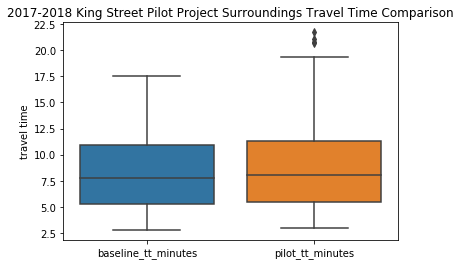

In [3]:
#Here is the overall baseline and pilot tt data in boxplots. 

ax = sns.boxplot(order = ["baseline_tt_minutes","pilot_tt_minutes"], data = df)
ax.set_ylabel('travel time')
ax.set_title('2017-2018 King Street Pilot Project Surroundings Travel Time Comparison')
plt.show()

We can conclude the travel time after pilot project increased on other streets because no vehicle can go through King Street. More data can be collected to investigate. Below is a statistic method to determine
whether the pilot travel time satisfies the 95% confidence interval from the travel time before pilot project. 
Generate a Bootstrap Sample from pilot and calculate its mean.

In [28]:
def bootstrap_replicate_1d(data, func):
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

bootstrap_replicate_1d(df.pilot_tt_minutes, np.mean)

8.608611825192803

Find the 95% confidence interval of this bootstrap sample

In [29]:
def draw_bs_reps(data, func, size = 1):
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)
        
    return bs_replicates
bs_replicates = draw_bs_reps(df.pilot_tt_minutes, np.mean, 100000)

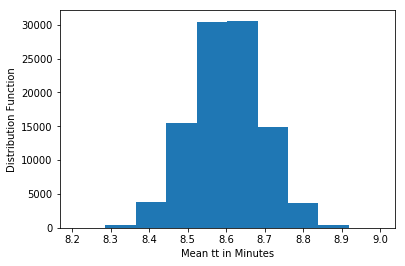

In [30]:
#Generating a normal distribution in mean pilot tt minutes
_ = plt.hist(bs_replicates, bins = 10)
_ = plt.xlabel('Mean tt in Minutes')
_ = plt.ylabel('Distribution Function')
plt.show()

In [31]:
#95% confidence interval, very small range only between 8.4 to 8.78 minutes
conf_int = np.percentile(bs_replicates, [2.5, 97.5])
conf_int

array([8.42172237, 8.78239235])

Since the mean baseline tt is 8.262725 minutes, the lower limit of the 95% confidence interval for pilot is 8.424 minutes. The bootstrap sample does not satisfy the baseline requirement. More up to date data need to be collected to see if the tt dropped down or obtain more baseline tt data prior to the project.  Investigate streets with outlier tt to see if any other solutions can reduce the tt. These are only probablistic results. The criteria of determining a decision varies and should be carefully considered and discussed.